# Merging EB terms-  NLS -  Encyclopaedia Britannica


### Loading the necessary libraries

In [53]:
import yaml
import matplotlib.pyplot as plt
import numpy as np
import collections
import matplotlib as mpl

In [54]:
import pandas as pd
from yaml import safe_load
from pandas.io.json import json_normalize

### Functions

In [55]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = safe_load(f)
    return query_results


In [56]:
def write_query_results(filename, results):
    with open('./results_NLS/'+filename, 'w') as f:
        documents = yaml.dump(results, f)

In [57]:
def create_dataframe(query_results):
    for page in query_results:
        column_list=list(query_results[page][0].keys())
        break
        
    data=[]
    for page in query_results:
        try:
            for element in query_results[page]:
                data.append(element)
               
        except:
            pass
    return pd.DataFrame(data, columns = column_list)

In [58]:
def create_dataframe_from_file(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = safe_load(f)
    
    for page in query_results:
        column_list=list(query_results[page][0].keys())
        break
        
    data=[]
    for page in query_results:
        try:
            for element in query_results[page]:
                data.append(element)
        except:
            pass
    return pd.DataFrame(data, columns = column_list)

In [59]:
def prune_json(json_dict):
    """
    Method that given a JSON object, removes all its empty fields.
    This method simplifies the resultant JSON.
    :param json_dict input JSON file to prune
    :return JSON file removing empty values
    """
    final_dict = {}
    if not (isinstance(json_dict, dict)):
        # Ensure the element provided is a dict
        return json_dict
    else:
        for a, b in json_dict.items():
            if b or isinstance(b, bool):
                if isinstance(b, dict):
                    aux_dict = prune_json(b)
                    if aux_dict:  # Remove empty dicts
                        final_dict[a] = aux_dict
                elif isinstance(b, list):
                    aux_list = list(filter(None, [prune_json(i) for i in b]))
                    if len(aux_list) > 0:  # Remove empty lists
                        final_dict[a] = aux_list
                else:
                    final_dict[a] = b
    return final_dict

In [60]:
def merge_terms(query_results):
    for page in query_results:
        for element in query_results[page]:
            if "previous_page" in element['term']:
                current_page=int(element['text_unit_id'].split("Page")[1])
                current_definition= element["definition"]
                previous_page_number= current_page-1
                previous_page=previous_page_number
                num_article_words=element["num_article_words"]
                related_terms=element["related_terms"]
                try:
                    if query_results[previous_page]:
                        flag_prev = 1
                except:
                    flag_prev = 0
                while not flag_prev:
                    previous_page_number = previous_page_number -1
                    previous_page=previous_page_number
                    try: 
                        if query_results[previous_page]:
                            flag_prev = 1
                    except:
                        flag_prev = 0
        
                #print("Current Page %s - Previous Page %s" %(element['text_unit_id'], previous_page))
                for prev_elements in query_results[previous_page]:
                    if prev_elements["last_term_in_page"]:
                        prev_elements["definition"]+=current_definition
                        prev_elements["num_article_words"]+=num_article_words
                        prev_elements["related_terms"]+= related_terms
                    
                    prev_elements["num_page_words"]+=num_article_words
                    
                for update_element in query_results[page]:
                    update_element["num_page_words"]-=num_article_words
                    update_element["num_articles"]-=1
                    
                element_index=query_results[page].index(element)
                del query_results[page][element_index]
    return query_results

In [61]:
query_results=read_query_results('results_eb_first_volume1')

In [62]:
query_results_updated=merge_terms(query_results)

In [63]:
#prune_results=prune_json(query_results_updated)

In [64]:
write_query_results("results_eb_first_volume1_updated", query_results)

In [65]:
#df=create_dataframe_from_file("results_eb_first_updated")

In [66]:
df=create_dataframe(query_results_updated)

In [67]:
df.head()

,archive_filename,definition,edition,header,last_term_in_page,model,num_article_words,num_articles,num_page_words,num_text_unit,...,related_terms,source_text_file,term,term_id_in_page,text_unit,text_unit_id,title,type_archive,type_page,year
0,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,n*s-f 7^' v L i A j J ^ /^^W / ; H:;^’ J }r-r£...,"First edition, 1771, Volume 1, A-B",iiiubnsfvnsfv,1,nlsArticles,58,1,59,832,...,[],alto/188082735.34.xml,iiiubnsfvnsfv,0,page,Page2,"Encyclopaedia Britannica; or, A dictionary of ...",book,FullPage,1771
1,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,S :u -I >;J .1 M U a C V',"First edition, 1771, Volume 1, A-B",**■*,1,nlsArticles,10,1,14,832,...,[],alto/188082813.34.xml,first_article,0,page,Page8,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
2,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,COVI PILED UPON A NEW PLAN. IN WHICH The difer...,"First edition, 1771, Volume 1, A-B",FrontPage,1,nlsArticles,91,1,90,832,...,[],alto/188082826.34.xml,FrontPage,0,page,Page9,"Encyclopaedia Britannica; or, A dictionary of ...",book,FullPage,1771
3,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,UTILITY ought to be the principal intention of...,"First edition, 1771, Volume 1, A-B",Preface,1,nlsArticles,363,1,374,832,...,[],alto/188082852.34.xml,Preface,0,page,Page11,"Encyclopaedia Britannica; or, A dictionary of ...",book,FullPage,1771
4,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"TH E Editors, though fully fen&ble of the prop...","First edition, 1771, Volume 1, A-B",viPREFACE,1,nlsArticles,410,1,416,832,...,[],alto/188082865.34.xml,viPREFACE,0,page,Page12,"Encyclopaedia Britannica; or, A dictionary of ...",book,Topic,1771


In [68]:
df.iloc[0]

archive_filename     /Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...
definition           n*s-f 7^' v L i A j J ^ /^^W / ; H:;^’ J }r-r£...
edition                             First edition, 1771, Volume 1, A-B
header                                                   iiiubnsfvnsfv
last_term_in_page                                                    1
model                                                      nlsArticles
num_article_words                                                   58
num_articles                                                         1
num_page_words                                                      59
num_text_unit                                                      832
place                                                        Edinburgh
related_terms                                                       []
source_text_file                                 alto/188082735.34.xml
term                                                     iiiubnsfvnsfv
term_i

In [69]:
print("The min number of articles per page is %s - the max is %s, and the average is %s" %(df["num_articles"].min(), df["num_articles"].max(), df["num_articles"].mean()))

The min number of articles per page is 1 - the max is 44, and the average is 20.17724494593324


In [70]:
df_related=df[df['related_terms'].apply(lambda x: len(x)) > 0]

In [71]:
df_related=df_related.explode('related_terms')

In [72]:
df_related

,archive_filename,definition,edition,header,last_term_in_page,model,num_article_words,num_articles,num_page_words,num_text_unit,...,related_terms,source_text_file,term,term_id_in_page,text_unit,text_unit_id,title,type_archive,type_page,year
19,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"in ichthyology, a barbarous name of the zeus v...","First edition, 1771, Volume 1, A-B",EncyclopaediaBritannica,0,nlsArticles,19,22,655,832,...,ZEUS,alto/188082904.34.xml,ABACATUAIA,12,page,Page15,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
20,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"AY, a barbarous name of a species of the pfitt...","First edition, 1771, Volume 1, A-B",EncyclopaediaBritannica,0,nlsArticles,14,22,655,832,...,PSITTACUS,alto/188082904.34.xml,ABAC,13,page,Page15,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
22,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,See ABACUS.,"First edition, 1771, Volume 1, A-B",EncyclopaediaBritannica,0,nlsArticles,2,22,655,832,...,ABACUS,alto/188082904.34.xml,ABACISCUS,15,page,Page15,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
36,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"in botany, a fynonime of the calycanthus prtec...","First edition, 1771, Volume 1, A-B",ABAABB,0,nlsArticles,22,36,961,832,...,CALYCANTHUS,alto/188082917.34.xml,ABAI,8,page,Page16,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
37,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,See ABASED.,"First edition, 1771, Volume 1, A-B",ABAABB,0,nlsArticles,2,36,961,832,...,ABASED,alto/188082917.34.xml,ABAISSE,9,page,Page16,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"Ji-ole for a night together, that the (leant o...","First edition, 1771, Volume 1, A-B",BREWING,1,nlsArticles,1677,1,1690,832,...,ANCON,alto/188093203.34.xml,BREWING,0,page,Page807,"Encyclopaedia Britannica; or, A dictionary of ...",book,Topic,1771
3961,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"Ji-ole for a night together, that the (leant o...","First edition, 1771, Volume 1, A-B",BREWING,1,nlsArticles,1677,1,1690,832,...,BRIAR,alto/188093203.34.xml,BREWING,0,page,Page807,"Encyclopaedia Britannica; or, A dictionary of ...",book,Topic,1771
4124,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"a port-town of Egypt, situated on the western ...","First edition, 1771, Volume 1, A-B",BUFBUI,0,nlsArticles,52,24,1091,832,...,BUGLOSS,alto/188093359.34.xml,BUGIE,21,page,Page819,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
4142,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"an iron or leaden ball, pr ftiot, wherewith fi...","First edition, 1771, Volume 1, A-B",BULBUN,0,nlsArticles,18,14,944,832,...,BULLINGBROKE,alto/188093385.34.xml,BULLET,3,page,Page821,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771


In [73]:
import networkx as nx
graph_df = nx.from_pandas_edgelist(df_related, source='term', target='related_terms', edge_attr=True)

In [74]:
graph_df

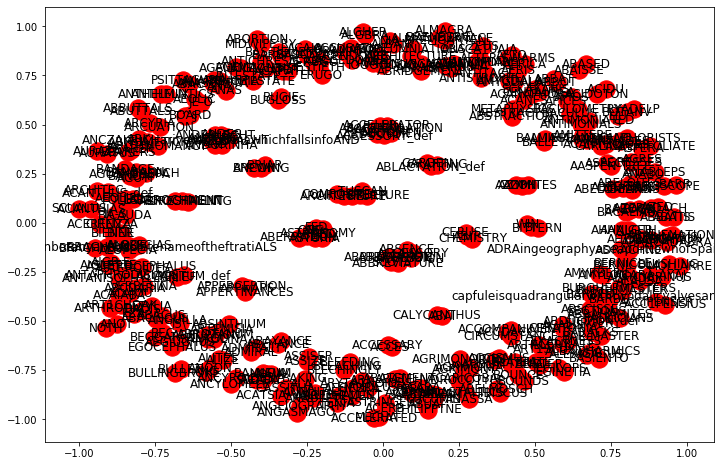

In [75]:
import matplotlib.pyplot as plt
#matplotlib inline

plt.figure(figsize=(12,8))
nx.draw_networkx(graph_df, with_labels=True)

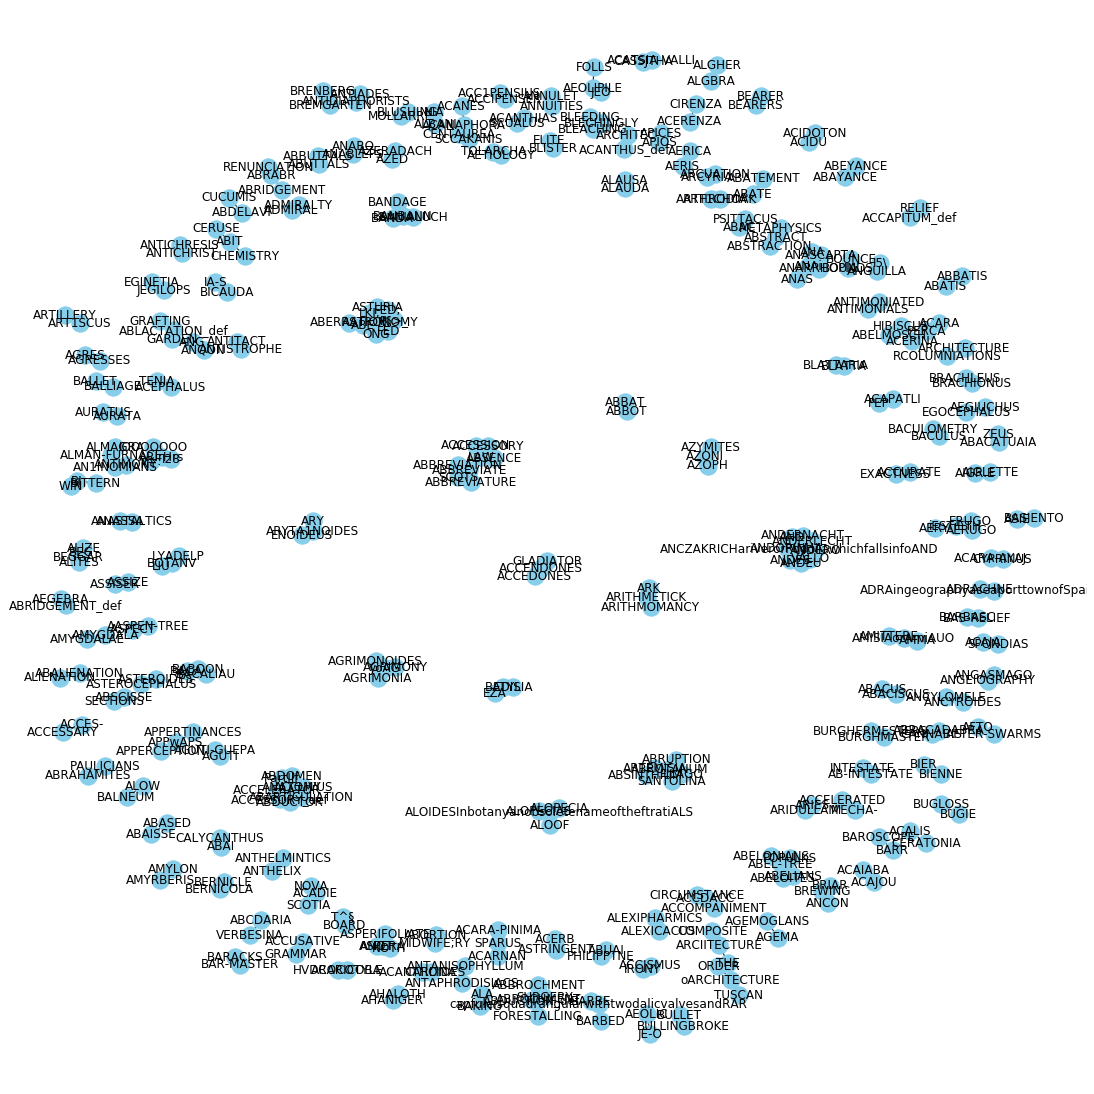

In [76]:
plt.figure(figsize=(15,15))

pos = nx.spring_layout(graph_df)
nx.draw(graph_df, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()